# Анализ ошибок модели

In [120]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
import lightgbm as lgb
import matplotlib.pyplot as plt

In [121]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

# Read data

In [122]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

In [123]:
pl.read_csv(os.path.join(data_path, 'action_type_info.csv'))

action_type,action_type_id
str,i64
"""click""",1
"""favorite""",2
"""order""",3
"""search""",4
"""to_cart""",5
"""view""",6


In [124]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [125]:
val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [126]:
def get_split(df, val_size=0.33, random_state = 42):
    np.random.seed(random_state)

    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

In [127]:
def train_model(tr, val, features, target_col, params=None, shadow_features=False, sklearn_style=False):

    tr_shadow, val_shadow = pd.DataFrame(), pd.DataFrame()

    X_tr = pd.concat([tr[features], tr_shadow], axis=1, sort=False)
    X_val = pd.concat([val[features], val_shadow], axis=1, sort=False)
    tr_lgb = lgb.Dataset(X_tr, tr[target_col])
    val_lgb = lgb.Dataset(X_val, val[target_col])

    params_ = {
        'nthread': 16,
        'objective': 'binary',
        'learning_rate': 0.01,
        'metric': 'auc',
        'verbose': -1
    }
    if params is not None:
        params_.update(params)

    if not sklearn_style:
        model = lgb.train(params_, tr_lgb, num_boost_round=300, valid_sets=[val_lgb], callbacks=[lgb.early_stopping(100)])
    else:
        model = lgb.LGBMClassifier(**params, n_estimators=300)
        model.fit(X_tr, tr[target_col], eval_set=[(X_val, val[target_col])], callbacks=[lgb.early_stopping(100)])
    
    if shadow_features:
        return model, tr_shadow.columns, X_tr, X_val
    return model

In [128]:
def plot_lgbm_importance(model, features, importance_type='split', top_k=20, sklearn_style=False, imps=None, round_to=0):
    if sklearn_style and imps is None:
        imps = model.feature_importances_
    elif imps is None:
        imps = model.feature_importance(importance_type=importance_type)
        
    idx = np.argsort(imps)
    sorted_imps = imps[idx][::-1][:top_k][::-1]
    sorted_features = np.array(features)[idx][::-1][:top_k][::-1]
    if round_to == 0:
        sorted_imps = sorted_imps.astype(int)
    else:
        sorted_imps = np.round(sorted_imps, round_to)
        
    bar_container = plt.barh(width=sorted_imps, y=sorted_features)
    plt.bar_label(bar_container, sorted_imps, color='red')
    plt.gcf().set_size_inches(5, top_k/6 + 1)
    plt.xlabel(importance_type, fontsize=15)
    sns.despine()


# Simple pipeline

## Feats

In [129]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite",
    3: "order",
    5: "to_cart",
}
for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information
            .select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
        .select(
            'user_id',
            f'num_products_{suf}',
            f'sum_discount_price_{suf}',
            f'max_discount_price_{suf}',
            f'days_since_last_{suf}',
            f'days_since_first_{suf}',
        )
    )
    actions_aggs[id_] = aggs

In [130]:
# search_aggs
id_ = 4
suf = 'search'
actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    )
)

In [131]:
actions_aggs.keys()

dict_keys([1, 2, 3, 5, 4])

In [132]:
df = val_target
for _, actions_aggs_df in actions_aggs.items():
    df = (
        df
        .join(actions_aggs_df, on='user_id', how='left')
    )

In [133]:
df

user_id,target,num_products_click,sum_discount_price_click,max_discount_price_click,days_since_last_click,days_since_first_click,num_products_favorite,sum_discount_price_favorite,max_discount_price_favorite,days_since_last_favorite,days_since_first_favorite,num_products_order,sum_discount_price_order,max_discount_price_order,days_since_last_order,days_since_first_order,num_products_to_cart,sum_discount_price_to_cart,max_discount_price_to_cart,days_since_last_to_cart,days_since_first_to_cart,num_search,days_since_last_search,days_since_first_search
i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,i32,i32
7380735,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3836585,0,11,10656.0,1640.0,102,102,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,14,36,102
8455604,0,1,415.0,415.0,53,53,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6,53,53
2978665,0,1,981.0,981.0,89,89,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
10324655,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6345949,0,31,39857.0,2712.0,2,104,null,null,null,null,null,15,6230.0,1721.0,14,64,18,11220.0,2712.0,14,64,42,2,104
9721534,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1753821,0,1,532.0,532.0,43,43,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4,43,43


In [134]:
df_pd = df.to_pandas()

Все проводится на сэмпле для быстроты

In [135]:

df_pd = df_pd.sample(100_000)


Для примера добавил кнн

In [136]:
from local_utils import *

knn_cols = ['max_discount_price_order']
df_pd = test_knn_features(df_pd, knn_cols, n_neighbors=6, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done
KNN features created


In [137]:
lgb_tr, lgb_val = get_split(df_pd, val_size=0.3)

cols = list(set(df_pd.columns) - {'user_id', 'target'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'num_iterations': 300,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

lgb_model = train_model(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 23972, number of negative: 46028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7127
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 35
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342457 -> initscore=-0.652363
[LightGBM] [Info] Start training from score -0.652363
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with 

feature_importance: [ 45  40 105  45  30 113  67  73  78 107   0  52 107   9   7  15  69   0
  76  80   4   6 116   4  58   7  45   3  41 113  45   6   0  54  81   0] 



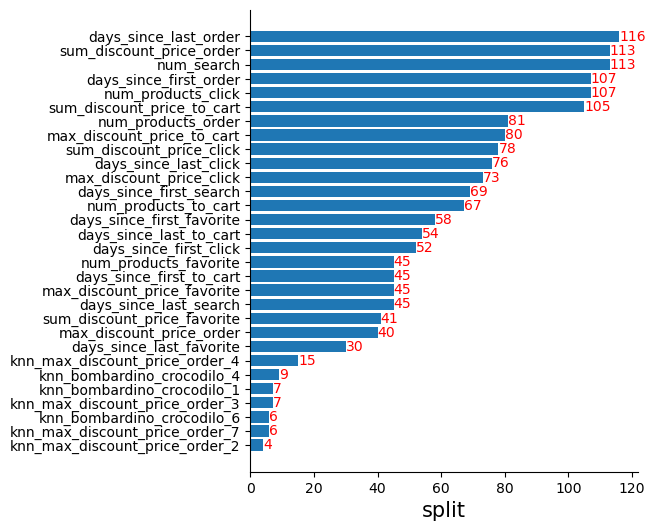

In [138]:
print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [139]:
from typing import List, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator

def feature_error_cor(
    model: BaseEstimator,
    df: pd.DataFrame,
    cols: List[str],
    n: int = 30
) -> None:
    """
    Анализирует ошибки модели и выводит тепловую карту корреляции признаков с величиной ошибки.

    Параметры:
    ----------
    model : sklearn.base.BaseEstimator
        Обученная модель с методом predict_proba().
    df : pandas.DataFrame
        Датафрейм, содержащий признаки и целевую переменную 'target'.
    cols : List[str]
        Список признаков, для которых вычисляется корреляция с ошибкой предсказания.
    n : int, optional (default=30)
        Количество топовых признаков для отображения.

    Возвращяеи:
    -----------
    None
        Функция выводит:
        1) Статистику по ошибочным предсказаниям
        2) Тепловую карту корреляции признаков с величиной ошибки
    """
    # Вероятности
    test_predictions: np.ndarray = model.predict_proba(df[cols])[:, 1]
    
    # Создаем датафрейм с ошибочными предсказаниями
    wrong_predictions: pd.DataFrame = df.assign(
        predicted_prob=test_predictions,
        predicted_class=(test_predictions > 0.5).astype(int)
    ).query(
        "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
    ).copy()
    
    # Вычисляем величину ошибки (разница между предсказанием и таргетом)
    wrong_predictions['error_magnitude']: pd.Series = np.abs(
        wrong_predictions['predicted_prob'] - wrong_predictions['target']
    )

    # Общая статистика по предсказаниям
    print(f"Всего ошибочных предсказаний: {len(wrong_predictions)}")
    print(f"Доля ошибок: {len(wrong_predictions)/len(df):.2%}")

    # Ложно положительные и ложно отрицательные предсказания. 
    fp: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 0]
    fn: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 1]

    print(f"Неверно предсказали 1 (FP): {len(fp)} ({len(fp)/len(wrong_predictions):.2%})")
    print(f"Неверно предсказали 0 (FN): {len(fn)} ({len(fn)/len(wrong_predictions):.2%})")

    # Вычисляем корреляцию признаков с велечиной ошибки. 
    corr_data: pd.DataFrame = wrong_predictions[cols].corrwith(
        wrong_predictions['error_magnitude']
    ).to_frame('correlation')
    
    # Сортируем и выводим n
    corr_data_sorted: pd.DataFrame = corr_data.sort_values(
        'correlation', 
        key=abs, 
        ascending=False
    ).head(n)

    # Строим хитмэп
    plt.figure(figsize=(6, 20))
    sns.heatmap(
        corr_data_sorted,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt='.2f',
        cbar_kws={'orientation': 'horizontal'}
    )
    plt.title('Корреляция признаков с величиной ошибки')
    plt.tight_layout()
    plt.show()

Всего ошибочных предсказаний: 23126
Доля ошибок: 23.13%
Неверно предсказали 1 (FP): 5019 (21.70%)
Неверно предсказали 0 (FN): 18107 (78.30%)


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


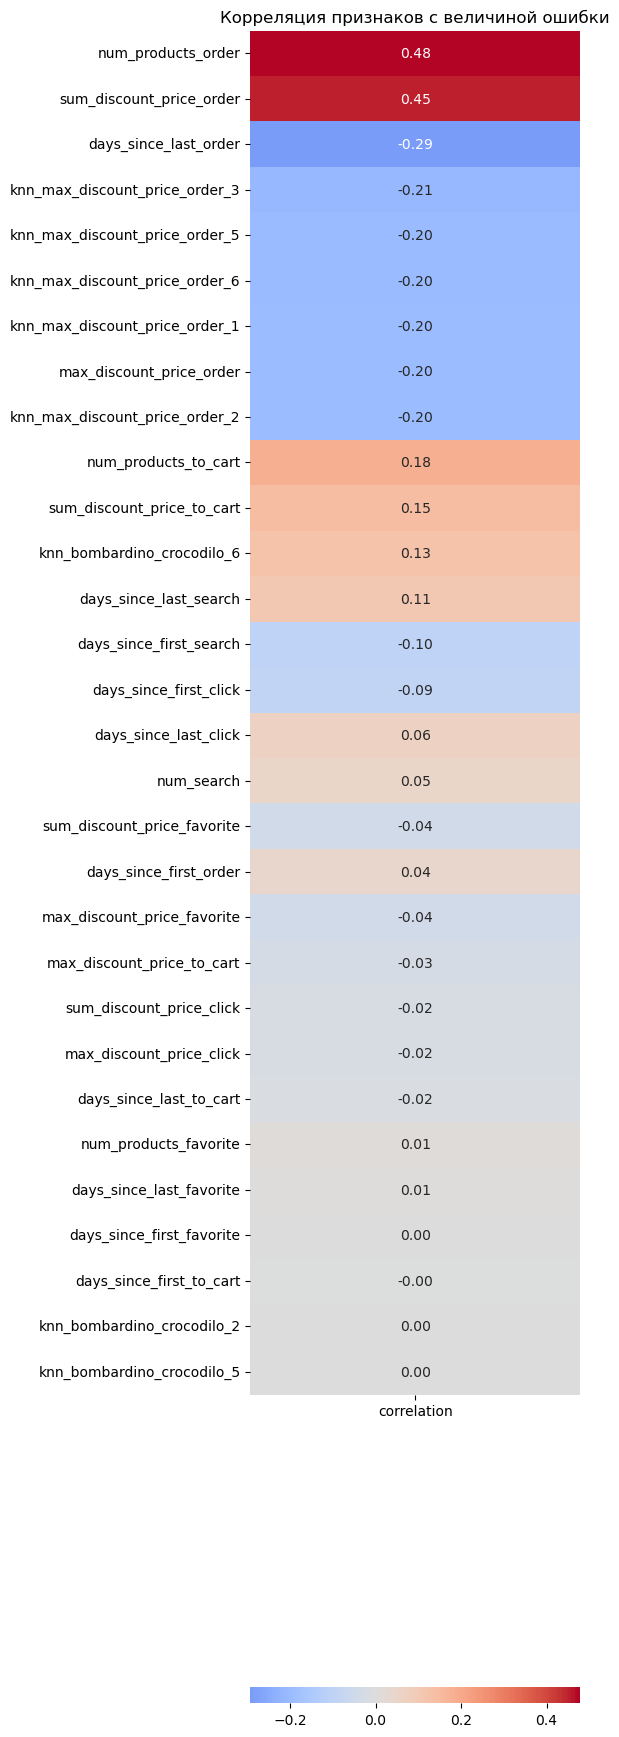

In [140]:
feature_error_cor(lgb_model, df_pd, cols)

# Интерпретация

---------------------------------------------

График показывает, как велчина ошибки модели зависит от значения каждого признака. 

Большая положительная коррелация ознакает, что при увеличиении значения такого признака велечина ошибки модели тоже увеличивается. С отрицательными наоборот, чем меньше значение признака, тем больше ошибка. 

Из этого не следует, что такие признаки нужно сносить. Они могут быть критически важными в одних дианозонах, но слабыми в других. Имеет смысл поработать с ними или добавить новые признаки для слабых диапозонов. 

Далее стоит рассмотреть важность фичей, анализировать распределение на них меток и генерировать новые признаки, закрывающие недостатки модели. 

---------------------------------------------